Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
C:\Users\Admin\AppData\Local\Temp\ipykernel_42112\1467451650.py:131: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


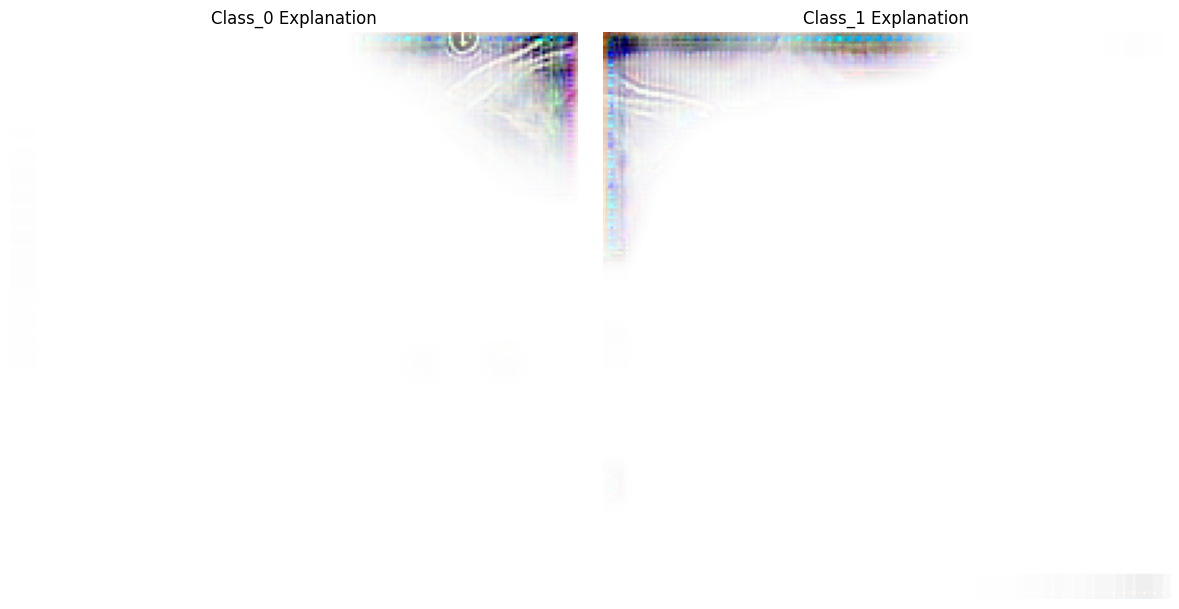

Probabilities: tensor([[0.5699, 0.4301]])
Binary Predictions: tensor([0])


In [ ]:
import os
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import pandas as pd
from torchvision.transforms import functional as TF
from PIL import Image
import pydicom 
import random
import matplotlib.pyplot as plt
import warnings
from typing import Dict, Any
from libraries.bcosconv2d import NormedConv2d
from bcos.common import BcosUtilMixin
from bcos.models.resnet import BcosResNet, Bottleneck

from torchvision.models.resnet import ResNet

model_path_better = r"C:\Users\Admin\Documents\MasterThesis\results\ResNet50_BCos\light_oversamp_nonorm\seed_0\pneumonia_detection_model_resnet_bcos_bestf1_1.pth"

class CustomBcosMixin:
    def explain(
        self,
        in_tensor,
        idx=None,
        explain_all_classes=False,
        threshold=0.5,
        **grad2img_kwargs,
    ) -> "Dict[str, Any]":
        """
        Generates an explanation for the given input tensor.
        This is not a generic explanation method, but rather a helper for simply getting explanations.
        It is intended for simple use cases (simple exploration, debugging, etc.).

        Parameters
        ----------
        in_tensor : Tensor
            The input tensor to explain. Must be 4-dimensional and have batch size of 1.
        idx : int, optional
            The index of the output to explain. If None, the prediction is explained.
        grad2img_kwargs : Any
            Additional keyword arguments passed to `gradient_to_image` method
            for generating the explanation.

        Returns
        -------
        Dict[str, Any]
            A dictionary containing the explanation and additional information.
            Namely, the following keys are present:
            - "prediction": The prediction of the model.
            - "explained_class_idx": The class (index) of the explained output.
            - "dynamic_linear_weights": The dynamic linear weights of the model (`in_tensor.grad`).
            - "contribution_map": The contribution map of the model prediction.
            - "explanation": The explanation of the model prediction.
        """
        if in_tensor.ndim == 3:
            raise ValueError("Expected 4-dimensional input tensor")
        if in_tensor.shape[0] != 1:
            raise ValueError("Expected batch size of 1")
        if not in_tensor.requires_grad:
            warnings.warn(
                "Input tensor did not require grad! Has been set automatically to True!"
            )
            in_tensor.requires_grad = True  # nonsense otherwise
        if self.model.training:  # noqa
            warnings.warn(
                "Model is in training mode! "
                "This might lead to unexpected results! Use model.eval()!"
            )

        result = dict()
        self.model.eval()
        with torch.enable_grad(), self.explanation_mode():
            # Forward pass + prediction using self.model
            out = self.model(in_tensor)
            pred_out = out.max(1)
            result["prediction"] = pred_out.indices.item()

            # Select output (logit) to explain
            if idx is None:  # Explain prediction
                to_be_explained_logit = pred_out.values
                result["explained_class_idx"] = pred_out.indices.item()
            else:  # User-specified idx
                to_be_explained_logit = out[0, idx]
                result["explained_class_idx"] = idx

            # Compute gradients for single class
            to_be_explained_logit.backward(inputs=[in_tensor])

        # Use gradients directly without manual normalization
        result["dynamic_linear_weights"] = in_tensor.grad
        result["contribution_map"] = (in_tensor * in_tensor.grad).sum(1)

        # Generate color explanation using gradient_to_image function
        result["explanation"] = self.gradient_to_image(
            in_tensor[0], result["dynamic_linear_weights"][0], **grad2img_kwargs
        )

        return result

class CustomModelWrapper(BcosUtilMixin):
    def __init__(self, pretrained_model):
        super().__init__()
        self.model = pretrained_model

    def forward(self, x):
        return self.model(x)

    def modules(self):
        return self.model.modules()


    # need to change to sigmoid!!!! for actually using it
    # Override the explain method to use the model attribute correctly
    def explain(
        self,
        in_tensor,
        idx=None,
        explain_all_classes=False,
        threshold=0.5,
        **grad2img_kwargs,
    ) -> "Dict[str, Any]":
        # Call the explain method from CustomBcosMixin but use self.model for predictions
        if in_tensor.ndim == 3:
            raise ValueError("Expected 4-dimensional input tensor")
        if in_tensor.shape[0] != 1:
            raise ValueError("Expected batch size of 1")
        if not in_tensor.requires_grad:
            warnings.warn(
                "Input tensor did not require grad! Has been set automatically to True!"
            )
            in_tensor.requires_grad = True  # nonsense otherwise
        if self.model.training:  # noqa
            warnings.warn(
                "Model is in training mode! "
                "This might lead to unexpected results! Use model.eval()!"
            )

        result = dict()
        self.model.eval()
        with torch.enable_grad(), self.explanation_mode():
            # Manually set explanation mode for the wrapped model
            for m in self.model.modules():
                if hasattr(m, "set_explanation_mode"):
                    m.set_explanation_mode(True)

            # fwd + prediction using self.model
            out = self.model(in_tensor)  # Use self.model for predictions
            probs = torch.softmax(out, dim=1)
            binary_preds = torch.argmax(probs, dim=1)

            result["probabilities"] = probs.detach().cpu()
            result["binary_predictions"] = binary_preds.detach().cpu()

            grads = []
            contribution_maps = []

            for class_idx in range(out.shape[1]):
                grad = torch.autograd.grad(
                    outputs=out[0, class_idx],
                    inputs=in_tensor,
                    retain_graph=True,
                    create_graph=False,
                    only_inputs=True,
                )[0]
                
                grads.append(grad)
                contribution_maps.append((in_tensor * grad).sum(1).squeeze(0))

            result["contribution_maps"] = torch.stack(contribution_maps)
            result["dynamic_linear_weights"] = torch.stack(grads)

            result["explanations"] = {}
            if explain_all_classes:
                # Generate explanations for all classes
                for idx in range(out.shape[1]):
                    result["explanations"][f"class_{idx}"] = self.gradient_to_image(
                        in_tensor[0], grads[idx][0], **grad2img_kwargs
                    )
            else:
                # Generate explanations only for predicted classes
                active_classes = torch.where(binary_preds)[0]
                for idx in active_classes:
                    result["explanations"][f"class_{idx}"] = self.gradient_to_image(
                        in_tensor[0], grads[idx][0], **grad2img_kwargs
                    )

            # Manually reset explanation mode for the wrapped model
            for m in self.model.modules():
                if hasattr(m, "set_explanation_mode"):
                    m.set_explanation_mode(False)

        return result

    
# Load the pretrained model
pretrained_model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
pretrained_model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network
state_dict_better = torch.load(model_path_better)
pretrained_model.load_state_dict(state_dict_better)
pretrained_model.eval()
custom_wrapper = CustomModelWrapper(pretrained_model)

# Load your image

image_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images\014b7b58-f641-4477-8bbc-ae6f337745d6.dcm"
dicom = pydicom.dcmread(image_path)
image = dicom.pixel_array
image = Image.fromarray(image).convert("RGB")
tensor_image = TF.to_tensor(image)
numpy_image = (tensor_image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
pil_image = Image.fromarray(numpy_image)

transformed_image = pretrained_model.transform(pil_image)
transformed_image = transformed_image[None]

expl = custom_wrapper.explain(in_tensor=transformed_image, explain_all_classes=True)
explanations = expl["explanations"]

# Create a figure with subplots for each class
fig, axes = plt.subplots(1, len(explanations), figsize=(12, 6))

# Loop through each class and plot its explanation
for idx, (class_name, explanation) in enumerate(explanations.items()):
    ax = axes[idx]
    im = ax.imshow(explanation, cmap='viridis')  # Use a colormap like 'viridis'
    ax.set_title(f"{class_name.capitalize()} Explanation")
    ax.axis('off')
plt.tight_layout()
plt.show()

print("Probabilities:", expl["probabilities"])
print("Binary Predictions:", expl["binary_predictions"])
